# Relax Inc. Data Science Sample Take Home Challenge
The  data  is  available  as  two  attached  CSV  files:
    takehome_user_engagement. csv
    takehome_users . csv
The  data  has  the  following  two  tables:

1]  A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years.   This  table  includes:
- name:  the  user's  name
- object_id:   the  user's  id
- email:  email  address
- creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:
    - PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
    - GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
    - ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
    - SIGNUP:  signed  up  via  the  website
    - SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)
- creation_time:  when  they  created  their  account
- last_session_creation_time:   unix  timestamp  of  last  login
- opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails
- enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
- org_id:   the  organization  (group  of  users)  they  belong  to
- invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

2]  A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .

## Load the data

In [99]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#from pandas_profiling import ProfileReport
%matplotlib inline

In [100]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')

In [101]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [102]:
users.shape

(12000, 10)

In [103]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [104]:
engagement.shape

(207917, 3)

## Label Adopted Users
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period , identify which factors predict future user adoption .

In [105]:
#check how many users and how many logins
print('There were {} users and {} total logins'.format(
    engagement['user_id'].nunique(), len(engagement)
))

There were 8823 users and 207917 total logins


In [106]:
import datetime

#set the time_stamp to datetime and the set it as the index
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)
engagement = engagement.set_index('time_stamp', drop= True)

In [107]:
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [108]:
from datetime import timedelta

def label_adopted(user_id):    
    """
    Input a user_id, returns whether or not they have been active within any 7-day period
    """
    df_temp = engagement.loc[engagement['user_id'] == user_id] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day.
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [109]:
#apply to user df to label users as adopted=true 
users['adopted_user'] = users['object_id'].apply(label_adopted)

In [110]:
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.138


## Data Wrangling

#### Remove unnecessary columns in users.
By reading the definition of each column, and link columns to our goal of this project. We will find several columns are useless.

User name,email address and invited_by_user_id will not help us for building the model.So we need to remove these two columns.



In [111]:
#users = users.drop(['name', 'email', 'invited_by_user_id'], axis=1)

In [112]:
#users.head()

#### Convert time stamps to datetime

In [113]:
# convert creation_time
users['creation_time'] = pd.to_datetime(users['creation_time'], format='%Y-%m-%d %H:%M:%S')

In [114]:
# convert last_session_creation_time
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [115]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


#### Create a new feature called history. 
This feature will tell us how long has the user been using this product. The account history might be a good factor to predict if the user is active.

In [116]:
# calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days

In [117]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,history
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,5.0


#### Look for duplicate rows

In [120]:
duplicateRowsUser = users[users.duplicated()]
print("There are/is {} duplicate rows in users".format(len(duplicateRowsUser)))

There are/is 0 duplicate rows in users


#### Missing Values

In [121]:
print(users.isna().sum())
users.info()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
history                       3177
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_

There are 3177 missing values in last_session_creation_time (unix timestamp of last login), and history. Since the information of last_session_creation_time has been included in the history column. We can just remove last_session_creation_time, and fill na in history with 0.   
There are 5583 missing values in invited_by_user_id. Fill na with 0.

In [127]:
users = users.drop(['last_session_creation_time'], axis=1)
users['history']=users['history'].fillna(0)
users['invited_by_user_id']=users['history'].fillna(0)

In [128]:
print(users.shape)
print(users.isna().sum())

(12000, 11)
object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted_user                  0
history                       0
dtype: int64


In [129]:
#There is no missing values in engagement
print(engagement.isna().sum())
engagement.info()

user_id    0
visited    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  207917 non-null  int64
 1   visited  207917 non-null  int64
dtypes: int64(2)
memory usage: 4.8 MB


## EDA

#### Adopted users vs non adopted

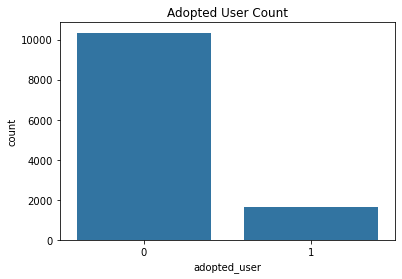

In [130]:
sns.countplot(users['adopted_user'],color='C10')
plt.title("Adopted User Count");

#### opted_in_to_mailing_list 

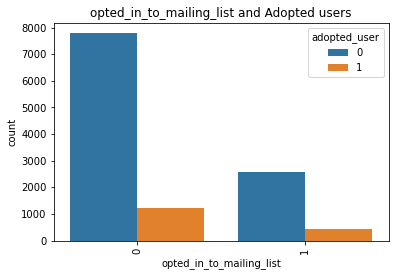

In [131]:
# opted_in_to_mailing_list and adopted user
sns.countplot(x='opted_in_to_mailing_list', data=users, hue='adopted_user')
plt.xticks(rotation=90)
plt.title("opted_in_to_mailing_list and Adopted users");
#There are slightly more adopted users if the users opted into receiving marketing emails

In [132]:
# Check the adpoted rate
users.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.136243
1    0.143287
Name: adopted_user, dtype: float64

There are more users did opted into receiving marketing emails. However, users did opted into receiving marketing emails has a higher chance to be adopte.

#### Creation source

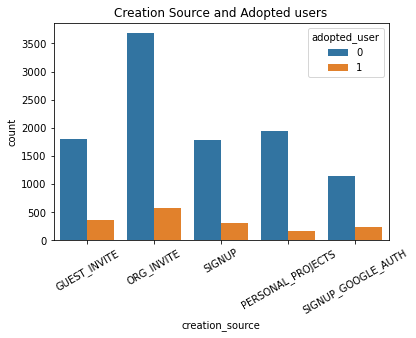

In [165]:
# Creation source and adopted user
sns.countplot(x='creation_source', data=users, hue='adopted_user')
plt.xticks(rotation=90)
plt.title("Creation Source and Adopted users")
plt.xticks(rotation=30);
# ORG_Invited has the most users and more adopted users

In [134]:
# Check the adpoted rate
users.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

Users that are org_invited are the most population.There are slightly higher "adopted user" rate in guest_invite and signup_google_auth.

#### History

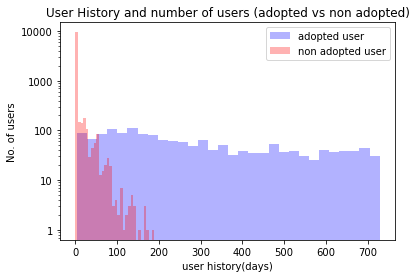

In [159]:
plt.hist(users.loc[users['adopted_user']==1, 'history'], bins=30, alpha=0.3, color='b', label='adopted user')
plt.hist(users.loc[users['adopted_user']==0, 'history'], bins=30, alpha=0.3, color='r', label='non adopted user')
plt.yscale('log')
plt.legend()
plt.xlabel('user history(days)')
plt.ylabel('No. of users')
plt.yticks([1, 10, 100, 1000, 10000], ['1', '10', '100', '1000', '10000'])
plt.title("User History and number of users (adopted vs non adopted)");

User history is defined as the number of days from account creation to the latest session. 
If a user has been using this product for more than 100 days, the user will have a higher chance to be an adopted user. If the user has been using this product for more than 200 days, the user will almost always be an adopted user.

One thing that need to pay attention here is that most users only use this product for a very short time. And the user numbers quickly decreased over usage time. This product probobaly need to do more to retain its users.

## Feature Engineering

By reading the definition of each column, and link each column to our goal of this project. We will find several columns are useless.

Remove the columns containing features that won't be useful for analysis. This includes object_id, creation_time, name, email, invited_by_user_id.

In [137]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted_user', 'history'],
      dtype='object')

In [139]:
users = users.drop(['object_id', 'creation_time', 'name', 'email','invited_by_user_id'], axis=1)

In [140]:
users.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,history
0,GUEST_INVITE,1,0,11,0,0.0
1,ORG_INVITE,0,0,1,1,136.0
2,ORG_INVITE,0,0,94,0,0.0
3,GUEST_INVITE,0,0,1,0,1.0
4,GUEST_INVITE,0,0,193,0,5.0


In [142]:
# Get dummy variables
creation_source = pd.get_dummies(users['creation_source'])
model_data = pd.concat([users, creation_source], axis=1).drop('creation_source', axis=1)
X = model_data.drop('adopted_user', axis=1)
y = model_data['adopted_user']

In [150]:
# create training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Building the model
I will use Random Forest method to build the prediction model.

In [152]:
# use random forest model with balanced class weights to correct for imbalance in the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
gs = GridSearchCV(clf, params,cv=5,scoring='accuracy')
gs.fit(X_train, y_train)
print('Best parameters were', gs.best_params_)
print('Best average precision was', gs.best_score_)

Best parameters were {'n_estimators': 100}
Best average precision was 0.9676616915422886


## Evalutate the model

In [153]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.9704545454545455
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.91      0.87      0.89       553

    accuracy                           0.97      3960
   macro avg       0.95      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960



Confusion matrix, without normalization
[[3360   47]
 [  70  483]]
Normalized confusion matrix
[[0.99 0.01]
 [0.13 0.87]]


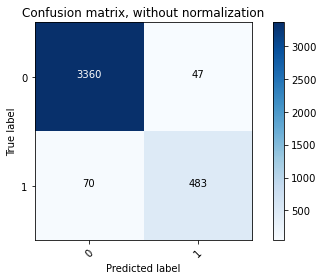

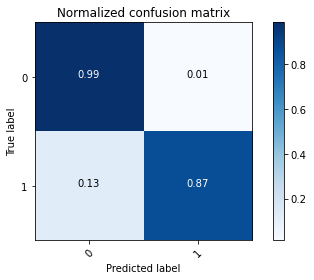

In [155]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

In [156]:
# take a look at feature importance
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

history                       0.914684
org_id                        0.063959
PERSONAL_PROJECTS             0.006483
opted_in_to_mailing_list      0.003427
enabled_for_marketing_drip    0.002812
SIGNUP_GOOGLE_AUTH            0.002497
GUEST_INVITE                  0.002145
SIGNUP                        0.002008
ORG_INVITE                    0.001985
dtype: float64


history is the most important feature to predict future user adoption. Based on this, I recommend that an effective way of growing adopted users might be encouraging existing users to log in and use the product after they had accounts for a while.

The next important feature is the organization id. This indicated that some organizations are very active, and the organization will require or attract users to log-in and maybe do some group projects or activities together. My recommendation is that the company could encourage or set up more group activities so the organizations will encourage its group members to login the product more often.

Personal_projects is the thirst important feature. However, based on the previous EDA, this feature has a very high chance to be a negative effect to "adoption rate". This might indicate that people do projects without a teammate has a higher chance to give up and stop using the product. My recommendation is that encourage the personal project users to find a teammate and do their projects together.
